# Wine

In [2]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
sys.path.append(str(Path(os.getcwd()).parents[1]))

%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [3]:
from jax import config
config.update("jax_enable_x64", True)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [6]:
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, mse, mae, train_test_split
from steinRF.baselines import build_svgp, build_train_svgp, svgp_predict, svgp_cross_val, svgp_nlpd
from steinRF.gp.models import *

In [7]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data Preparation

In [8]:
key = jax.random.PRNGKey(0)

In [9]:
wine = pd.read_csv("wine.csv")
X, y = jnp.array(wine.iloc[:, :-1]), jnp.array(wine["quality"])
y = y.reshape(-1)
X_scaler = StandardScaler().fit(X)
X = jnp.array(X_scaler.transform(X))
y_scaler = StandardScaler().fit(y.reshape(-1, 1))
y = jnp.array(y_scaler.transform(y.reshape(-1, 1)).reshape(-1))

X_train, X_val, y_train, y_val = train_test_split(key, X, y, test_size=0.1)

## Hyperparameter Optimization

In [10]:
# total settings
diag_min, diag_max = 1e-4, 3e-1
epoch_min, epoch_max = 500, 4000
lr_min, lr_max = 1e-3, 4e-1
alpha_min, alpha_max = 0., 3.
q_min, q_max = 2, 10
s_vals = [0, 0.5, 1, 2]

# --------------------------------- Sparse Variational GP -------------------------------- #
def _svgp_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", 5e-4, 0.1, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = svgp_cross_val(key, X, y, cv_params)
    return cross_val_acc


# ---------------------------------- RFF GP - RBF Kernel --------------------------------- #
def rff_rbf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff_rbf, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- RFF BASIC -------------------------------------- #
def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, cv_params)
    return cross_val_acc

# --------------------------------------- STEIN RFF -------------------------------------- #
def srf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha, 
        's': s, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_srf, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------------ MIXTURE KERNEL ------------------------------------ #
def mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, 'kernel': 'rbf', **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params)
    return cross_val_acc


# ---------------------------------- MMD MIXTURE KERNEL ---------------------------------- #
def mmd_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, 'kernel': 'mmd', **params
    }

    # run cross valœ
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params)
    return cross_val_acc


### Run Optimization

In [11]:
n_trials = 30
R = 100
q = 10
hparams = {}

#### Sparse-Variational GP

In [ ]:
# {'R': R, 'epochs': 1000, 'lr': 0.01, 'diag': 0.1}
svgp_study = run_hyperopt(
    _svgp_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, diag=1e-2, from_data=False
)
hparams["svgp"] = svgp_study.best_params

#### RFF with RBF

In [ ]:
# {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}
rff_rbf_study = run_hyperopt(
    rff_rbf_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000
)
hparams["rff_rbf"] = rff_rbf_study.best_params
# rff_rbf = build_rff_rbf(key, X_train, 100, 1e-2)

#### Basic RFF GP

In [ ]:
# rff = build_train_rff(
#     key, X_train, y_train, R=R, diag=0.09, lr=0.024, epochs=1000, from_data=False, init_ls=False
# )[0]
rff_study = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, from_data=False
)
hparams["rff"] = rff_study.best_params

#### Stein Random Features

In [19]:
srf_study = run_hyperopt(
    srf_cross_val, key, X_train, y_train, n_trials=50, R=R, epochs=1000, from_data=False, s=0.5
)
hparams["srf"] = srf_study.best_params

[I 2024-02-09 22:05:40,911] A new study created in memory with name: no-name-e8686d99-fc45-4df6-ba2c-2d768730db1e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-02-09 22:06:00,841] Trial 0 finished with value: 1.5433295589736018 and parameters: {'diag': 0.0032839775980045465, 'lr': 0.018527040254311584, 'lr_gd': 0.005253311428235241, 'alpha': 2.2}. Best is trial 0 with value: 1.5433295589736018.
[I 2024-02-09 22:06:19,880] Trial 1 finished with value: 1.0105962345927584 and parameters: {'diag': 0.0002465441387649931, 'lr': 0.10088373739580178, 'lr_gd': 0.0016379851704509034, 'alpha': 2.0}. Best is trial 1 with value: 1.0105962345927584.
[I 2024-02-09 22:06:38,820] Trial 2 finished with value: 0.9552097107689965 and parameters: {'diag': 0.00012120123964734215, 'lr': 0.19899670407313372, 'lr_gd': 0.045616901909306104, 'alpha': 1.2000000000000002}. Best is trial 2 with value: 0.9552097107689965.
[I 2024-02-09 22:06:57,869] Trial 3 finished with value: 1.085385611487149 and parameters: {'diag': 0.0225481614567996, 'lr': 0.2323091395859417, 'lr_gd': 0.037613644423428065, 'alpha': 2.4000000000000004}. Best is trial 2 with value: 0.9552097107

#### Mixture SRFR

In [12]:
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=50, R=R, epochs=1000, from_data=False, lr_gd=0.1, q=10, # s=0,
    # gd_params=lambda t: [t.kernel.transform.scale], init_ls=False
)

[I 2024-05-31 00:41:33,655] A new study created in memory with name: no-name-890be822-ed70-4b6d-b82b-01ba8b4cc5f9


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-31 00:45:41,315] Trial 0 finished with value: 0.7111566078136462 and parameters: {'diag': 0.07819215295997307, 'lr': 0.00164497930312614, 'alpha': 0.8, 's': 0}. Best is trial 0 with value: 0.7111566078136462.
[I 2024-05-31 00:49:47,669] Trial 1 finished with value: 0.6657103300492448 and parameters: {'diag': 0.1509663246005096, 'lr': 0.012804008785335141, 'alpha': 2.2, 's': 0}. Best is trial 1 with value: 0.6657103300492448.
[I 2024-05-31 00:53:53,892] Trial 2 finished with value: 0.8302312712053063 and parameters: {'diag': 0.11855085443950582, 'lr': 0.04092614898949178, 'alpha': 1.0, 's': 2}. Best is trial 1 with value: 0.6657103300492448.
[I 2024-05-31 00:58:00,101] Trial 3 finished with value: 0.8419601353312313 and parameters: {'diag': 0.0006500951265951438, 'lr': 0.0015492533762313937, 'alpha': 1.4000000000000001, 's': 0}. Best is trial 1 with value: 0.6657103300492448.
[I 2024-05-31 01:02:06,142] Trial 4 finished with value: 0.8663198792584469 and parameters: {'diag': 

#### Mixture SRFR (MMD)

In [13]:
# mix_rff = build_mix_rff(key, X_train, diag=1e-2, q=5, R=100, alpha=1.4, lr=0.05, from_data=False, epochs=1000)
mmd_rff_study = run_hyperopt(
    mmd_rff_cross_val, key, X_train, y_train, n_trials=50, R=R, epochs=1000, from_data=False, s=0, q=10, lr_gd=0.1
    # gd_params=lambda t: [t.kernel.transform.scale], init_ls=False
)

[I 2024-05-31 04:06:54,187] A new study created in memory with name: no-name-6065be84-a962-44fc-bd5d-eb73812851e1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-31 04:10:52,999] Trial 0 finished with value: 0.6356409228287534 and parameters: {'diag': 0.08828134008274488, 'lr': 0.02672313369449761, 'alpha': 1.2000000000000002}. Best is trial 0 with value: 0.6356409228287534.
[I 2024-05-31 04:14:51,812] Trial 1 finished with value: 0.5618428245387529 and parameters: {'diag': 0.0054082403854675675, 'lr': 0.16159829206670642, 'alpha': 0.2}. Best is trial 1 with value: 0.5618428245387529.
[I 2024-05-31 04:18:50,699] Trial 2 finished with value: 0.5903879384950419 and parameters: {'diag': 0.03503459328675347, 'lr': 0.13775695532374999, 'alpha': 3.0}. Best is trial 1 with value: 0.5618428245387529.
[I 2024-05-31 04:22:49,159] Trial 3 finished with value: 0.5567473032342946 and parameters: {'diag': 0.00029784623834694087, 'lr': 0.16758813481042728, 'alpha': 0.2}. Best is trial 3 with value: 0.5567473032342946.
[I 2024-05-31 04:26:47,595] Trial 4 finished with value: 0.763701874876648 and parameters: {'diag': 0.00043940386382157817, 'lr': 0.

## Define and Run Experiment

In [9]:
def experiment_run(exp_key, X, y, scaler, params, R, restarts=1):
    
    # split data
    X_tr, X_test, y_tr, y_test = train_test_split(exp_key, X, y, test_size=0.1)

    ############ SVGP ############
    svgp, _ = build_train_svgp(exp_key, X_tr, y_tr, R=R, **params["svgp"])
    svgp_preds, svgp_sd = svgp_predict(svgp, X_test)
    svgp_metrics = metric_model(y_test, svgp_preds, svgp_sd, scaler=scaler)
    svgp_metrics = jnp.concatenate([svgp_metrics, jnp.atleast_1d(svgp_nlpd(svgp, X_test, y_test))])

    ############ RFF RBF ############
    rff_rbf_gp, _ = build_train_rff_rbf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff_rbf"])
    rff_rbf_preds, rff_rbf_sd = rff_rbf_gp.condition(y_tr, X_test)
    rff_rbf_metrics = metric_model(y_test, rff_rbf_preds, rff_rbf_sd, scaler=scaler)
    rff_rbf_metrics = jnp.concatenate([
        rff_rbf_metrics, jnp.atleast_1d(rff_rbf_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF ############
    rff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff"])
    rff_preds, rff_sd = rff_gp.condition(y_tr, X_test)
    rff_metrics = metric_model(y_test, rff_preds, rff_sd, scaler=scaler)
    rff_metrics = jnp.concatenate([
        rff_metrics, jnp.atleast_1d(rff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF-Q ############
    # RFF with the equilvalent number of R as the computational complexity of the mixture.
    q = params["mix_rff"]["q"]
    R_equiv_q = int((q * R**3)**(1/3))
    qrff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R_equiv_q, restarts=restarts, **params["rff"])
    qrff_preds, qrff_sd = qrff_gp.condition(y_tr, X_test)
    qrff_metrics = metric_model(y_test, qrff_preds, qrff_sd, scaler=scaler)
    qrff_metrics = jnp.concatenate([
        qrff_metrics, jnp.atleast_1d(qrff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ SRF ############
    srf_gp, _ = build_train_srf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["srf"])
    srf_preds, srf_sd = srf_gp.condition(y_tr, X_test)
    srf_metrics = metric_model(y_test, srf_preds, srf_sd, scaler=scaler)
    srf_metrics = jnp.concatenate([
        srf_metrics, jnp.atleast_1d(srf_gp.nlpd(y_tr, X_test, y_test))
    ])    

    ############ MIX ############
    mix_gp, _ = build_train_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["mix_rff"])
    mix_preds, mix_sd = mix_gp.condition(exp_key, y_tr, X_test)
    mix_metrics = metric_model(y_test, mix_preds, mix_sd, scaler=scaler)
    mix_metrics = jnp.concatenate([
        mix_metrics, jnp.atleast_1d(mix_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ MMD ############
    mmd_gp, _ = build_train_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["mmd_rff"])
    mmd_preds, mmd_sd = mmd_gp.condition(exp_key, y_tr, X_test)
    mmd_metrics = metric_model(y_test, mmd_preds, mmd_sd, scaler=scaler)
    mmd_metrics = jnp.concatenate([
        mmd_metrics, jnp.atleast_1d(mmd_gp.nlpd(y_tr, X_test, y_test))
    ])

    metrics = {
        "seed": int(exp_key[1]),
        "svgp": svgp_metrics,
        "rff_rbf": rff_rbf_metrics,
        "rff": rff_metrics,
        "qrff": qrff_metrics,
        "srf": srf_metrics,
        "mix": mix_metrics,
        "mmd": mmd_metrics
    }

    return metrics

In [10]:
def multi_run(multi_key, X, y, scaler, params, R, n_runs=5):
    metrics = []
    run_keys = jax.random.split(multi_key, n_runs)

    for i in range(n_runs):
        print(f"Running experiment {i+1} of {n_runs}")
        run_res = experiment_run(run_keys[i], X, y, scaler, params, R)
        metrics.append(run_res)
        print(run_res)
    
    return metrics

### Run

In [11]:
KEY, subkey = jax.random.split(jax.random.PRNGKey(2024))

params = {
    "svgp": {'lr': 0.012254389326799639, 'epochs': 1000, 'diag': 0.01, 'from_data': False},  # done
    "rff_rbf": {'diag': 0.08566575956727521, 'lr': 0.004409934867766953, 'epochs': 1000},  # done
    "rff": {'diag': 0.0972108582915608, 'lr': 0.024882896481772398, 'epochs': 1000, 'from_data': False},  # done
    "srf": {
        'diag': 0.0035583713233748263, 'lr': 0.17355927300317128, 'lr_gd': 0.2290394111784337, 'alpha': 1.8,
        'epochs': 1000, 's': 0.5, 'from_data': False
    },
    "mix_rff": {
        'diag': 0.025303143883163574, 'lr': 0.19585346870582462, 'alpha': 0.4, 's': 0.5,  'q': 10, 'kernel': 'rbf',
        'epochs': 1000, 'from_data': False, 'init_ls': True, 'lr_gd': 0.1
    },
    "mmd_rff": {
        'diag': 0.0003436182096973294, 'lr': 0.15841475389977153, 'alpha': 2.0, 'q': 10, 's': 0, 'kernel': 'mmd',
        # 'diag': 0.00010206553263266048, 'lr': 0.21827956269136686, 'alpha': 1.8, 'q': 10, 's': 0,
        'epochs': 1000, 'from_data': False, 'init_ls': True, 'lr_gd': 0.1
    },
}

In [38]:
# experiment_run(subkey, X, y, y_scaler, params, R=100)
res = multi_run(KEY, X, y, y_scaler, params, R=100, n_runs=10)

Running experiment 1 of 10
{'seed': 3007921430, 'svgp': Array([ 2.94192262e-01,  4.24602852e-01,  9.68553424e-01, -2.87022977e-03,
        2.00252563e+03], dtype=float64), 'rff_rbf': Array([ 6.61309904e-01,  6.78237906e-01,  3.96226406e-01, -1.48383352e-02,
        7.71873100e+02], dtype=float64), 'rff': Array([7.31735265e-01, 5.94367854e-01, 5.72327018e-01, 2.22502547e-03,
       7.58936897e+02], dtype=float64), 'qrff': Array([ 3.55339560e-01,  3.98407814e-01,  7.23270416e-01, -1.52681941e-02,
        2.94041944e+02], dtype=float64), 'srf': Array([ 4.34124979e-01,  4.96588279e-01,  1.44654080e-01, -5.92332867e-03,
        1.24770459e+04], dtype=float64), 'mix': Array([ 2.89783232e-01,  3.94275658e-01,  9.30817604e-01, -9.08936883e-03,
        1.77559768e+03], dtype=float64), 'mmd': Array([ 2.55552701e-01,  3.34090513e-01,  9.49685514e-01, -2.17673606e-03,
        1.54128425e+05], dtype=float64)}
Running experiment 2 of 10
{'seed': 2158071644, 'svgp': Array([ 3.80282516e-01,  4.7717975

In [ ]:
res_df = []
for exp in res:
    res_df.extend([[k, *v.tolist()] for k,v in exp.items() if k != "seed"])
res_df = pd.DataFrame(res_df, columns=["model", "mse", "mae", "cal", "z", "nlpd"])
res_df.to_csv("results_cr.csv", index=False)

## Evaluate

In [155]:
res_df = pd.read_csv("results_cr.csv")

names = {
    "rff": "RFF",
    "nrff": "Nonstationary RFF",
    "rff_rbf": "RFF-RBF",
    "svgp": "Sparse VGP",
    "srf": "Stein RFF",
    "qrff": "RFF Equiv Mix Big-O",
    "mix": "Stein Mixture RFF",
    "mmd": "MMD Mixture RFF",
    "nmix": "Nonstationary Stein Mixture RFF",
}

res_df["model"] = res_df["model"].apply(lambda x: names[x])
res_df["rmse"] = np.sqrt(res_df["mse"])
res_df["log_mse"] = np.log(res_df["mse"])

### Metrics

In [156]:
sum_df = res_df.groupby("model").agg(["mean", "std"])
sum_df.columns = sum_df.columns.map(lambda x: '_'.join(x) if isinstance(x, tuple) else x)
sum_df = sum_df.sort_values("rmse_mean", ascending=True).reset_index()
sum_df[['model', 'rmse_mean', 'rmse_std', "nlpd_mean", "nlpd_std"]]

,model,rmse_mean,rmse_std,nlpd_mean,nlpd_std
0,Stein Mixture RFF,0.592937,0.037144,1882.450982,205.274191
1,MMD Mixture RFF,0.613993,0.050765,166968.827607,13233.123118
2,Sparse VGP,0.621889,0.035377,2334.933257,456.981079
3,RFF Equiv Mix Big-O,0.691472,0.062420,404.044730,74.279168
4,Stein RFF,0.763794,0.058482,16924.909553,2615.702904
5,RFF-RBF,0.822428,0.079570,791.138023,160.650625
6,RFF,0.868052,0.043983,783.900682,82.316589


Text(0.5, 1.0, 'Wine UCI Dataset Error')

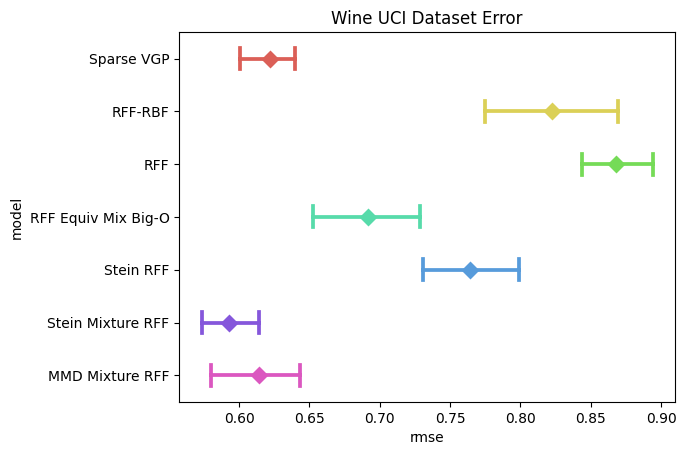

In [157]:
unique_models = res_df["model"].unique()
colors = sns.color_palette("hls", len(unique_models))

pointplot = sns.pointplot(
    data=res_df, x="rmse", y="model", hue="model",
    errorbar="ci", capsize=.4,
    palette=colors, legend=False,
    color=".5", linestyle="none", marker="D",
)
pointplot.set_title("Wine UCI Dataset Error")

## Learned Kernels

In [12]:
from steinRF.utils import mixture_pred_dists, plot_kernel_mixture, plot_mixture_preds

In [13]:
rff_gp, single_dist, mix_gp, mixture_dist, y_test = mixture_pred_dists(key, X, y, params, R=100, test_size=0.1)

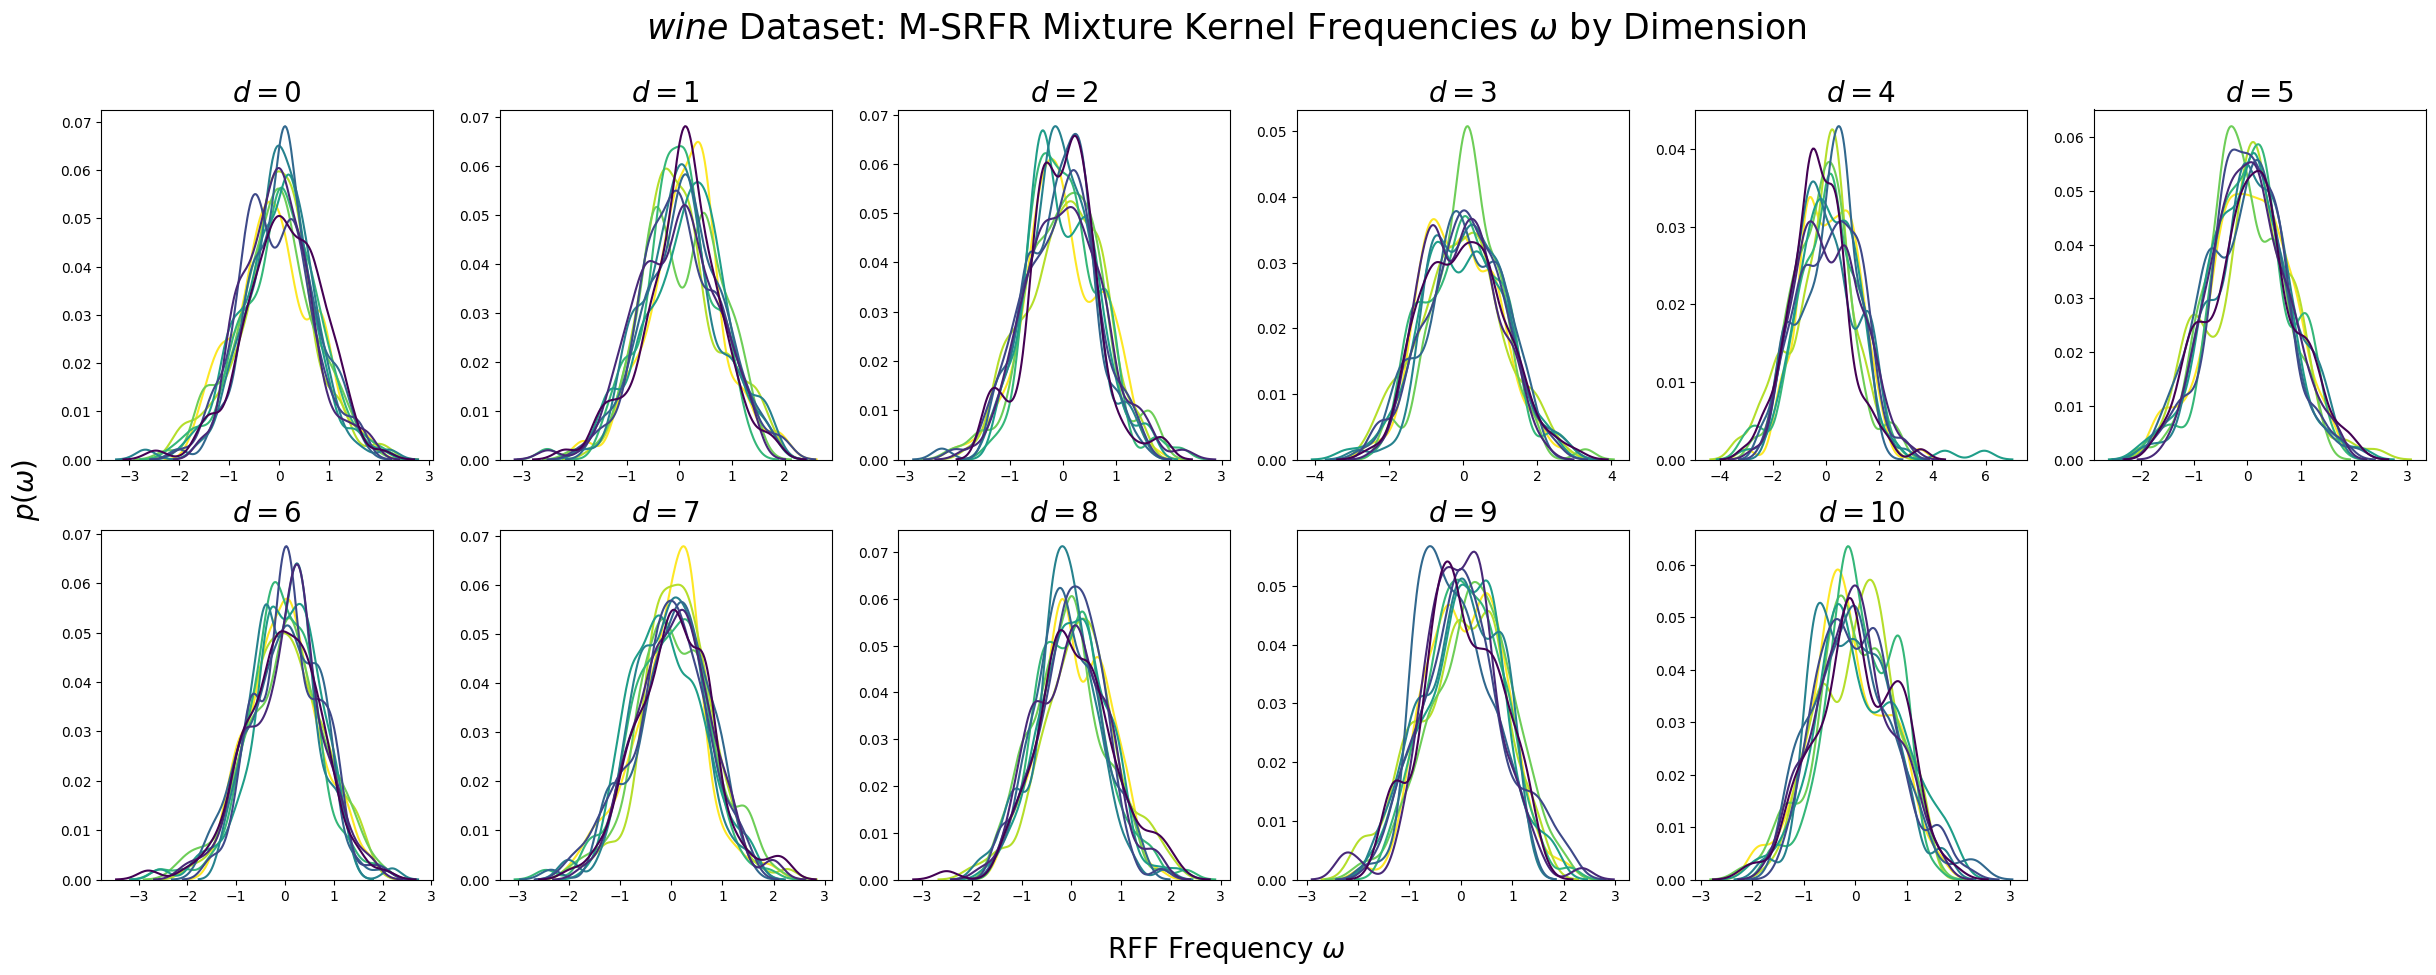

In [14]:
kernel_plot = plot_kernel_mixture(
    mix_gp.kernel.kernel.w, 6, bw_adjust=0.7, 
    title="$\\it{wine}$ Dataset: M-SRFR Mixture Kernel Frequencies $\omega$ by Dimension"
)
kernel_plot.savefig("../figures/wine_kernel.pdf", bbox_inches="tight", dpi=300, format="pdf")

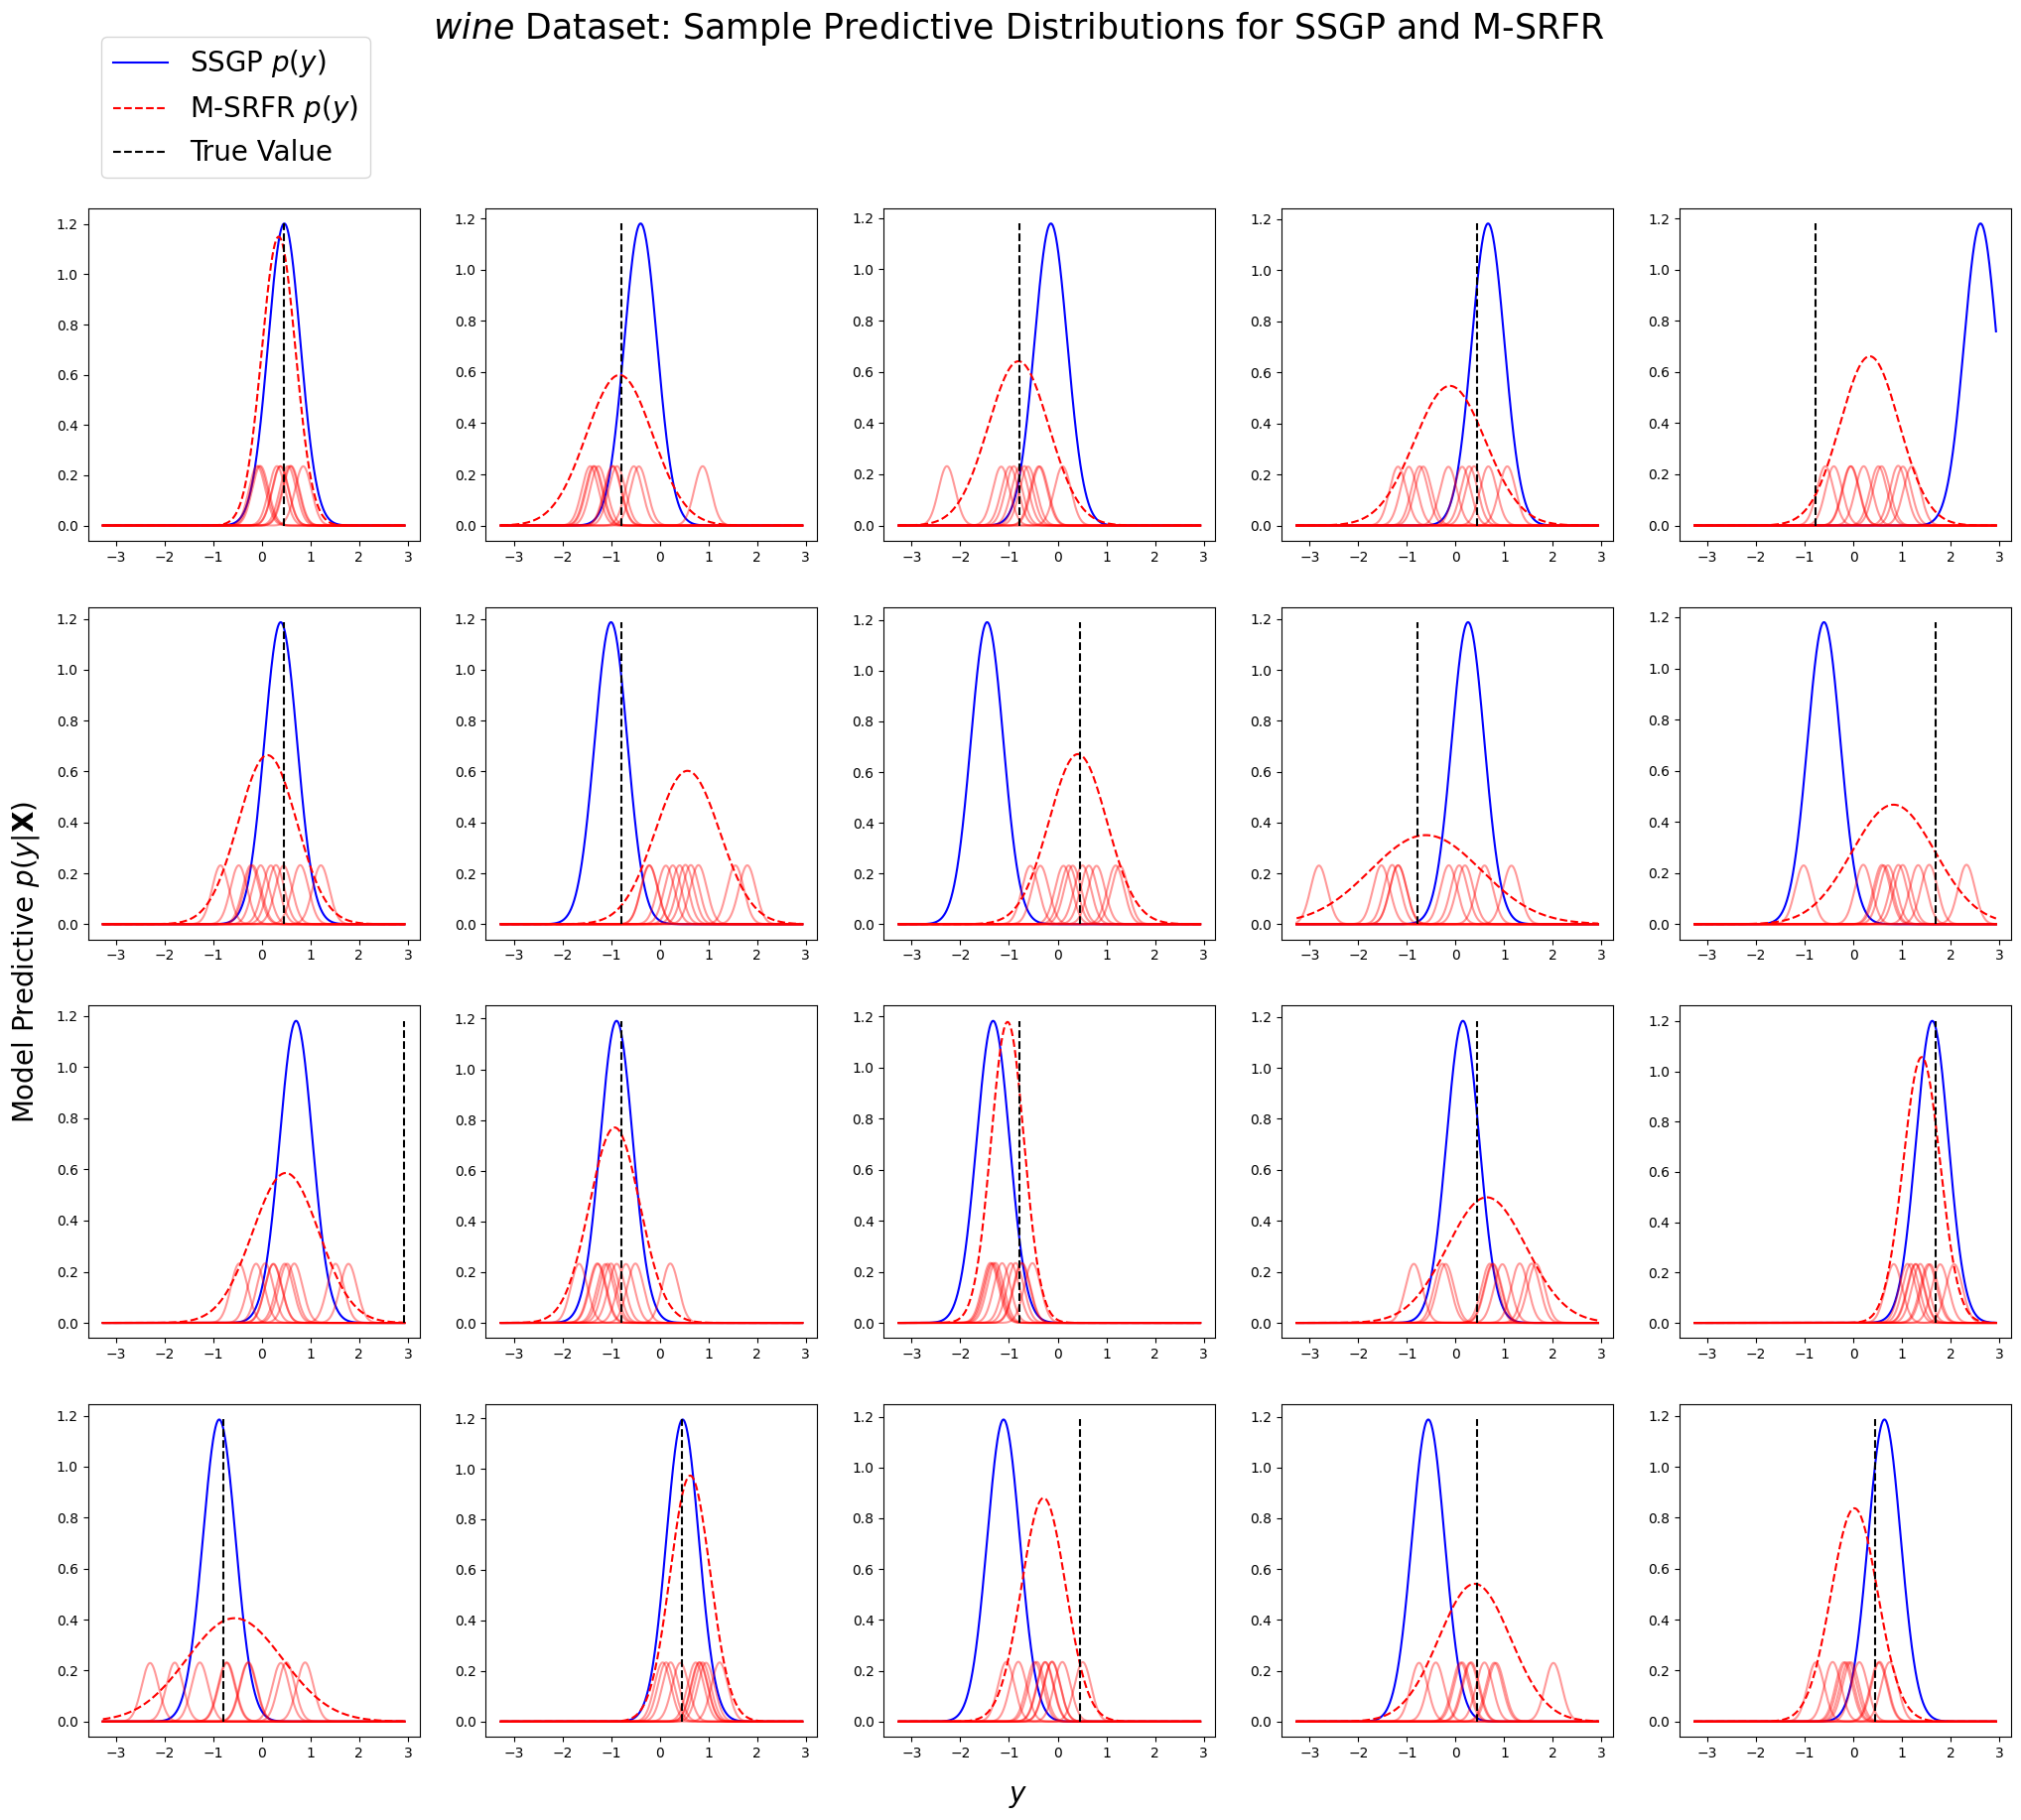

In [15]:
plot_key = jax.random.PRNGKey(2024)
plot_bounds = jnp.array([y.min(), y.max()])
pred_plot = plot_mixture_preds(
    single_dist, mixture_dist, y_test, n=20, 
    key=plot_key, standardize=False, bounds=plot_bounds,
    title="$\\it{wine}$ Dataset: Sample Predictive Distributions for SSGP and M-SRFR"
)
pred_plot.savefig("../figures/wine_preds.pdf", bbox_inches="tight", dpi=300, format="pdf")